In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("mateuszbuda/lgg-mri-segmentation")

print("Path to dataset files:", path)

100%|██████████| 714M/714M [00:24<00:00, 31.1MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/mateuszbuda/lgg-mri-segmentation/versions/2


In [2]:
# ===============================
#  Import Required Libraries
# ===============================

# --- System Utilities ---
import os                   # file & directory operations
import time                 # tracking runtime
import random               # random number generation
from pathlib import Path     # modern path handling
from glob import glob        # pattern-based file search
from tqdm.auto import tqdm   # progress bar (works both in notebook & terminal)

# --- Data & Image Processing ---
import numpy as np
import pandas as pd
import cv2                  # OpenCV for image processing
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from skimage.io import imread, imshow
from skimage.color import rgb2gray
from skimage.transform import resize
from skimage.morphology import label

# --- Deep Learning (TensorFlow / Keras) ---
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import (
    Input, Conv2D, Conv2DTranspose, MaxPooling2D, Dropout,
    BatchNormalization, Activation, Lambda, concatenate
)

# --- General Settings ---
import warnings
warnings.filterwarnings("ignore")

# Visualization setup
sns.set(style="darkgrid")
plt.rcParams["figure.figsize"] = (8, 6)


In [3]:
# ===============================================
#  Step 2: Organize dataset into a DataFrame
# ===============================================

# Dataset root (the path printed earlier from kagglehub)
DATASET_PATH = Path(path) / "kaggle_3m" # Navigate into the kaggle_3m subdirectory

# Collect all image and mask files by iterating through patient directories
image_files = []
mask_files = []

# Use glob to find all image and mask files with .tif extension
all_tif_files = glob(str(DATASET_PATH / "**" / "*.tif"), recursive=True)

for file_path in all_tif_files:
    if "_mask" in file_path:
        mask_files.append(file_path)
    else:
        image_files.append(file_path)

# Sort files to ensure image and mask pairs are in the same order
image_files.sort()
mask_files.sort()

print(f"Found {len(image_files)} images and {len(mask_files)} masks")

# Create DataFrame to link each image with its mask
df = pd.DataFrame({
    "image_path": image_files,
    "mask_path": mask_files
})
display(df.head())

Found 3929 images and 3929 masks


,image_path,mask_path
0,/root/.cache/kagglehub/datasets/mateuszbuda/lg...,/root/.cache/kagglehub/datasets/mateuszbuda/lg...
1,/root/.cache/kagglehub/datasets/mateuszbuda/lg...,/root/.cache/kagglehub/datasets/mateuszbuda/lg...
2,/root/.cache/kagglehub/datasets/mateuszbuda/lg...,/root/.cache/kagglehub/datasets/mateuszbuda/lg...
3,/root/.cache/kagglehub/datasets/mateuszbuda/lg...,/root/.cache/kagglehub/datasets/mateuszbuda/lg...
4,/root/.cache/kagglehub/datasets/mateuszbuda/lg...,/root/.cache/kagglehub/datasets/mateuszbuda/lg...


Image shape: (256, 256)
Mask shape: (256, 256)


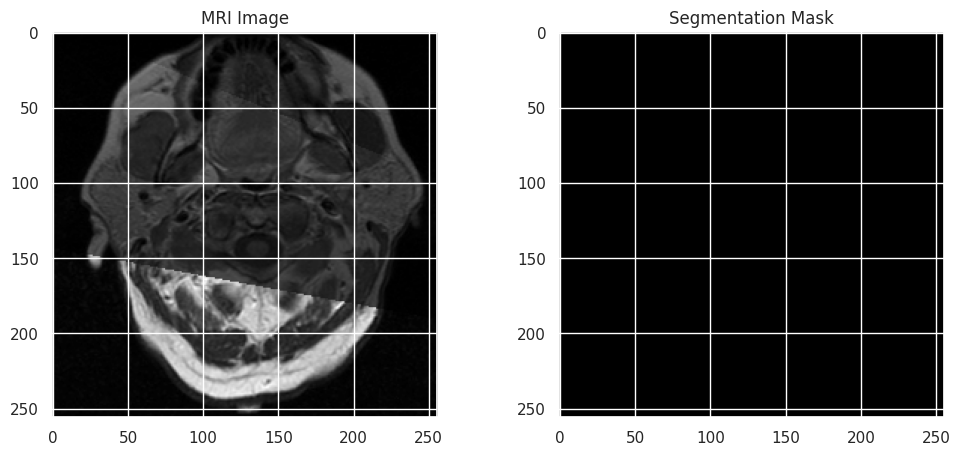

In [4]:
# ===============================================
#  Step 3: Load & visualize a sample image+mask
# ===============================================
import cv2 # OpenCV for image processing
import matplotlib.pyplot as plt

def load_tif_image(file_path):
    """Load a TIFF file and return numpy array."""
    img = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE) # Read as grayscale
    return img

# Pick one sample
sample_img_path  = df["image_path"].iloc[0]
sample_mask_path = df["mask_path"].iloc[0]

# Load image & mask
image = load_tif_image(sample_img_path)   # 2D MRI scan (assuming slices are treated as individual images)
mask  = load_tif_image(sample_mask_path)  # 2D segmentation mask

print("Image shape:", image.shape)
print("Mask shape:", mask.shape)

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.imshow(image, cmap="gray")
plt.title("MRI Image")

plt.subplot(1,2,2)
plt.imshow(mask, cmap="gray")
plt.title("Segmentation Mask")

plt.show()

In [5]:
# ==============================
#  UNet 2D Architecture (Keras)
# ==============================

from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, MaxPooling2D, Dropout, concatenate
from tensorflow.keras.models import Model

def build_unet(input_shape=(128, 128, 1), num_classes=1):
    """
    Build UNet architecture for image segmentation.

    Parameters:
        input_shape (tuple): Shape of the input image (H, W, C).
        num_classes (int): Number of output classes (1 for binary segmentation).

    Returns:
        model (tf.keras.Model): Compiled UNet model.
    """

    inputs = Input(input_shape)

    # ----- Encoder (Downsampling path) -----
    c1 = Conv2D(64, (3, 3), activation="relu", padding="same")(inputs)
    c1 = Conv2D(64, (3, 3), activation="relu", padding="same")(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(128, (3, 3), activation="relu", padding="same")(p1)
    c2 = Conv2D(128, (3, 3), activation="relu", padding="same")(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(256, (3, 3), activation="relu", padding="same")(p2)
    c3 = Conv2D(256, (3, 3), activation="relu", padding="same")(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(512, (3, 3), activation="relu", padding="same")(p3)
    c4 = Conv2D(512, (3, 3), activation="relu", padding="same")(c4)
    d4 = Dropout(0.5)(c4)
    p4 = MaxPooling2D((2, 2))(d4)

    # ----- Bottleneck -----
    c5 = Conv2D(1024, (3, 3), activation="relu", padding="same")(p4)
    c5 = Conv2D(1024, (3, 3), activation="relu", padding="same")(c5)
    d5 = Dropout(0.5)(c5)

    # ----- Decoder (Upsampling path) -----
    u6 = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding="same")(d5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(512, (3, 3), activation="relu", padding="same")(u6)
    c6 = Conv2D(512, (3, 3), activation="relu", padding="same")(c6)

    u7 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding="same")(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(256, (3, 3), activation="relu", padding="same")(u7)
    c7 = Conv2D(256, (3, 3), activation="relu", padding="same")(c7)

    u8 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding="same")(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(128, (3, 3), activation="relu", padding="same")(u8)
    c8 = Conv2D(128, (3, 3), activation="relu", padding="same")(c8)

    u9 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding="same")(c8)
    u9 = concatenate([u9, c1])
    c9 = Conv2D(64, (3, 3), activation="relu", padding="same")(u9)
    c9 = Conv2D(64, (3, 3), activation="relu", padding="same")(c9)

    # ----- Output Layer -----
    # num_classes = 1 → sigmoid (binary segmentation)
    # num_classes > 1 → softmax (multi-class segmentation)
    activation = "sigmoid" if num_classes == 1 else "softmax"
    outputs = Conv2D(num_classes, (1, 1), activation=activation)(c9)

    model = Model(inputs, outputs, name="UNet2D")
    return model


# Example: Create UNet model
unet_model = build_unet(input_shape=(128, 128, 1), num_classes=1)
unet_model.summary()

Model: "UNet2D"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │        640 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 128,  │     36,928 │ conv2d[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 64,    │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 64,    │    147,584 │ conv2d_2[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 32,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 32, 32,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 32, 32,    │    590,080 │ conv2d_4[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 16, 16,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 16, 16,    │  1,180,160 │ max_pooling2d_2[… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 16, 16,    │  2,359,808 │ conv2d_6[0][0]    │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 16, 16,    │          0 │ conv2d_7[0][0]    │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 8, 8, 512) │          0 │ dropout[0][0]     │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 8, 8,      │  4,719,616 │ max_pooling2d_3[… │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 8, 8,      │  9,438,208 │ conv2d_8[0][0]    │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 8, 8,      │          0 │ conv2d_9[0][0]  

 Total params: 31,030,593 (118.37 MB)

 Trainable params: 31,030,593 (118.37 MB)

 Non-trainable params: 0 (0.00 B)

In [6]:
# ==============================
# Compile UNet Model
# ==============================

from tensorflow.keras.optimizers import Adam

# Build the UNet model
unet_model = build_unet(input_shape=(128, 128, 1), num_classes=1)

# Compile the model
unet_model.compile(
    optimizer=Adam(learning_rate=1e-4),     # Optimizer
    loss="binary_crossentropy",             # Loss function (binary segmentation)
    metrics=["accuracy"]                    # Metrics to monitor
)

# Print model summary
unet_model.summary()

Model: "UNet2D"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_19 (Conv2D)  │ (None, 128, 128,  │        640 │ input_layer_1[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_20 (Conv2D)  │ (None, 128, 128,  │     36,928 │ conv2d_19[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 64, 64,    │          0 │ conv2d_20[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_21 (Conv2D)  │ (None, 64, 64,    │     73,856 │ max_pooling2d_4[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_22 (Conv2D)  │ (None, 64, 64,    │    147,584 │ conv2d_21[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 32, 32,    │          0 │ conv2d_22[0][0]   │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_23 (Conv2D)  │ (None, 32, 32,    │    295,168 │ max_pooling2d_5[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_24 (Conv2D)  │ (None, 32, 32,    │    590,080 │ conv2d_23[0][0]   │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_6     │ (None, 16, 16,    │          0 │ conv2d_24[0][0]   │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_25 (Conv2D)  │ (None, 16, 16,    │  1,180,160 │ max_pooling2d_6[… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_26 (Conv2D)  │ (None, 16, 16,    │  2,359,808 │ conv2d_25[0][0]   │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 16, 16,    │          0 │ conv2d_26[0][0]   │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_7     │ (None, 8, 8, 512) │          0 │ dropout_2[0][0]   │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_27 (Conv2D)  │ (None, 8, 8,      │  4,719,616 │ max_pooling2d_7[… │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_28 (Conv2D)  │ (None, 8, 8,      │  9,438,208 │ conv2d_27[0][0]   │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 8, 8,      │          0 │ conv2d_28[0][0] 

 Total params: 31,030,593 (118.37 MB)

 Trainable params: 31,030,593 (118.37 MB)

 Non-trainable params: 0 (0.00 B)

In [7]:
import tensorflow.keras.backend as K
import tensorflow as tf

# Optional: Add Dice Coefficient as a metric to improve segmentation evaluation
def dice_coefficient(y_true, y_pred, smooth=1):
    """
    Dice Coefficient = 2 * (|X ∩ Y|) / (|X| + |Y|)
    Measures overlap between predicted and true masks.
    """
    y_true = tf.cast(y_true, tf.float32)   # ensure same dtype
    y_pred = tf.cast(y_pred, tf.float32)

    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


In [8]:
#  Data Generators for Images & Masks

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import numpy as np

def load_and_preprocess(image_path, mask_path, target_size=(128, 128)):
    """Load and preprocess image and mask."""
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    # Resize images and masks
    image = cv2.resize(image, target_size)
    mask = cv2.resize(mask, target_size)

    # Add channel dimension for grayscale images if needed by the model
    image = np.expand_dims(image, axis=-1)
    mask = np.expand_dims(mask, axis=-1)

    # Normalize image
    image = image / 255.0
    mask = mask / 255.0

    return image, mask

# Split data into training and validation sets
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

def data_generator(dataframe, target_size=(128, 128), batch_size=16):
    """Custom data generator."""
    n = len(dataframe)
    i = 0
    while True:
        batch_images = []
        batch_masks = []
        for _ in range(batch_size):
            if i == n:
                i = 0 # Reset index for next epoch
                dataframe = dataframe.sample(frac=1).reset_index(drop=True) # Shuffle dataframe
            image, mask = load_and_preprocess(dataframe.iloc[i]["image_path"], dataframe.iloc[i]["mask_path"], target_size)
            batch_images.append(image)
            batch_masks.append(mask)
            i += 1
        yield np.array(batch_images), np.array(batch_masks)


# Create generators using the custom data generator
train_gen = data_generator(train_df, target_size=(128, 128), batch_size=16)
val_gen = data_generator(val_df, target_size=(128, 128), batch_size=16)

print(f"Training samples: {len(train_df)}")
print(f"Validation samples: {len(val_df)}")

Training samples: 3143
Validation samples: 786


In [9]:
# Callbacks (EarlyStopping & ModelCheckpoint)
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# EarlyStopping: stop training if validation loss doesn't improve
early_stopping = EarlyStopping(
    monitor="val_loss",      # monitor validation loss
    patience=10,             # number of epochs to wait before stopping
    restore_best_weights=True # restore best weights instead of last
)

# ModelCheckpoint: save the best model during training
checkpoint = ModelCheckpoint(
    filepath="best_unet_model.h5",   # path to save the best model
    monitor="val_loss",              # monitor validation loss
    save_best_only=True,             # save only if model is better
    verbose=1
)

# Put callbacks in a list to use in model.fit()
callbacks = [early_stopping, checkpoint]


In [ ]:
# ==============================
# Train UNet Model
# ==============================

# Number of steps per epoch = total_samples / batch_size
# Adjust these based on your dataset size
steps_per_epoch = 200   # example value (replace with len(train_dataset)//batch_size)
validation_steps = 50   # example value (replace with len(val_dataset)//batch_size)

history = unet_model.fit(
    train_gen,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_gen,
    validation_steps=validation_steps,
    epochs=50,
    callbacks=callbacks,
    verbose=1
)


Epoch 1/50
 20/200 ━━━━━━━━━━━━━━━━━━━━ 1:16:44 26s/step - accuracy: 0.9834 - loss: 0.6765

## Evaluate the Model and Visualize Predictions

In [ ]:
# Evaluate the model on the validation set
loss, accuracy, dice_score = unet_model.evaluate(val_gen, steps=validation_steps, verbose=0)

print(f"Validation Loss: {loss:.4f}")
print(f"Validation Accuracy: {accuracy:.4f}")
print(f"Validation Dice Score: {dice_score:.4f}")

In [ ]:
import random

def visualize_predictions(model, generator, num_samples=3):
    """
    Visualize a few predictions from the generator.
    Displays: Original Image, True Mask, and Predicted Mask.
    """
    # Take a random batch from the generator
    imgs, masks = next(generator)

    plt.figure(figsize=(15, num_samples * 5))

    for i in range(num_samples):
        # Extract image and corresponding true mask
        image = imgs[i]
        true_mask = masks[i]

        # Predict mask using the model
        pred_mask = model.predict(np.expand_dims(image, axis=0))[0]

        # Display original image
        plt.subplot(num_samples, 3, i * 3 + 1)
        plt.imshow(image.squeeze(), cmap="gray")
        plt.title("Original Image")
        plt.axis("off")

        # Display true mask
        plt.subplot(num_samples, 3, i * 3 + 2)
        plt.imshow(true_mask.squeeze(), cmap="gray")
        plt.title("True Mask")
        plt.axis("off")

        # Display predicted mask
        plt.subplot(num_samples, 3, i * 3 + 3)
        plt.imshow(pred_mask.squeeze(), cmap="gray")
        plt.title("Predicted Mask")
        plt.axis("off")

    plt.tight_layout()
    plt.show()


# Call the function to visualize 3 samples from the validation set
visualize_predictions(unet_model, val_gen, num_samples=3)


In [ ]:
# Save the trained model
unet_model.save("unet_segmentation_model.h5")
print("Model saved successfully!")


In [ ]:
# Plot training & validation metrics from history

def plot_training_history(history):
    """Plot training & validation loss, accuracy, and dice coefficient."""

    # Extract metrics from history
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    acc = history.history["accuracy"]
    val_acc = history.history["val_accuracy"]
    dice = history.history["dice_coefficient"]
    val_dice = history.history["val_dice_coefficient"]

    epochs = range(1, len(loss) + 1)

    plt.figure(figsize=(18, 5))

    # Loss
    plt.subplot(1, 3, 1)
    plt.plot(epochs, loss, "b-", label="Training Loss")
    plt.plot(epochs, val_loss, "r--", label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training vs Validation Loss")
    plt.legend()

    # Accuracy
    plt.subplot(1, 3, 2)
    plt.plot(epochs, acc, "b-", label="Training Accuracy")
    plt.plot(epochs, val_acc, "r--", label="Validation Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("Training vs Validation Accuracy")
    plt.legend()

    # Dice Coefficient
    plt.subplot(1, 3, 3)
    plt.plot(epochs, dice, "b-", label="Training Dice")
    plt.plot(epochs, val_dice, "r--", label="Validation Dice")
    plt.xlabel("Epochs")
    plt.ylabel("Dice Coefficient")
    plt.title("Training vs Validation Dice")
    plt.legend()

    plt.tight_layout()
    plt.show()


# Call the function
plot_training_history(history)


In [ ]:
def predict_on_new_image(model, image_path, target_size=(128, 128)):
    """
    Predict mask for a single new image (no ground truth mask required).
    """
    # Load the image
    image = imread(image_path)

    # Resize and normalize
    image_resized = resize(image, target_size, preserve_range=True) / 255.0

    # Expand dims for model input (batch dimension)
    input_image = np.expand_dims(image_resized, axis=0)

    # Predict mask
    pred_mask = model.predict(input_image)[0]

    # Show results
    plt.figure(figsize=(8, 4))

    # Original image
    plt.subplot(1, 2, 1)
    plt.imshow(image_resized.squeeze(), cmap="gray")
    plt.title("Original Image")
    plt.axis("off")

    # Predicted mask
    plt.subplot(1, 2, 2)
    plt.imshow(pred_mask.squeeze(), cmap="gray")
    plt.title("Predicted Mask")
    plt.axis("off")

    plt.tight_layout()
    plt.show()

    return pred_mask


# Example usage (replace with your test image path)
test_image_path = "path_to_your_test_image.jpg"
predicted_mask = predict_on_new_image(loaded_model, test_image_path)


#segmentation #
##Brain MRI Images for Brain Tumor Detection
 ##

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("navoneel/brain-mri-images-for-brain-tumor-detection")

print("Path to dataset files:", path)

In [ ]:
# ==============================
# Brain Tumor Classification
# ==============================

import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

# Path to dataset (the one printed by kagglehub)
dataset_path = path

# Image parameters
IMG_HEIGHT, IMG_WIDTH = 128, 128
BATCH_SIZE = 16

# Data generators
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2  # 20% for validation
)

train_gen = datagen.flow_from_directory(
    dataset_path,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode="binary",
    subset="training",
    shuffle=True
)

val_gen = datagen.flow_from_directory(
    dataset_path,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode="binary",
    subset="validation",
    shuffle=False
)


In [ ]:
# ==============================
# Brain Tumor Classification Model
# ==============================

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Build a simple CNN model
cnn_model = Sequential([
    Conv2D(32, (3,3), activation="relu", input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    MaxPooling2D(2,2),

    Conv2D(64, (3,3), activation="relu"),
    MaxPooling2D(2,2),

    Conv2D(128, (3,3), activation="relu"),
    MaxPooling2D(2,2),

    Flatten(),
    Dense(128, activation="relu"),
    Dropout(0.5),
    Dense(1, activation="sigmoid")  # binary classification
])

# Compile the model
cnn_model.compile(optimizer="adam",
                  loss="binary_crossentropy",
                  metrics=["accuracy"])

cnn_model.summary()


In [ ]:
# Train the CNN model
history_cls = cnn_model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10,
    verbose=1
)


In [ ]:
# Evaluate on validation data
val_loss, val_acc = cnn_model.evaluate(val_gen, verbose=0)
print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_acc:.4f}")


In [ ]:
# Plot accuracy and loss curves
plt.figure(figsize=(12,5))

# Accuracy
plt.subplot(1,2,1)
plt.plot(history_cls.history["accuracy"], label="Train Accuracy")
plt.plot(history_cls.history["val_accuracy"], label="Val Accuracy")
plt.title("Training vs Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

# Loss
plt.subplot(1,2,2)
plt.plot(history_cls.history["loss"], label="Train Loss")
plt.plot(history_cls.history["val_loss"], label="Val Loss")
plt.title("Training vs Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.show()


In [ ]:
# Import the metrics
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import seaborn as sns


In [ ]:
# Predict on validation data

# Get true labels
y_true = val_gen.classes

# Get predicted probabilities
y_pred_prob = cnn_model.predict(val_gen)

# Convert to binary labels (0 = no tumor, 1 = tumor)
y_pred = (y_pred_prob > 0.5).astype("int32")


In [ ]:
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["No Tumor", "Tumor"], yticklabels=["No Tumor", "Tumor"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


In [ ]:
# Classification Report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=["No Tumor", "Tumor"]))


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import random

# Get a batch of validation images
val_images, val_labels = next(val_gen)

# Predict on the batch
pred_probs = cnn_model.predict(val_images)
pred_labels = (pred_probs > 0.5).astype("int32").flatten()

# Define class names
class_names = ["No Tumor", "Tumor"]

# Show 9 random images
plt.figure(figsize=(12, 12))
for i in range(9):
    idx = random.randint(0, len(val_images) - 1)
    img = val_images[idx]
    true_label = val_labels[idx]
    pred_label = pred_labels[idx]

    plt.subplot(3, 3, i+1)
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"True: {class_names[int(true_label)]}\nPred: {class_names[int(pred_label)]}",
              color=("green" if true_label == pred_label else "red"))

plt.tight_layout()
plt.show()


In [ ]:
# Evaluation
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import seaborn as sns

# Predict on validation set
val_probs = cnn_model.predict(val_gen, steps=len(val_gen))
val_preds = (val_probs > 0.5).astype("int32").flatten()

# True labels
true_labels = val_gen.classes

# Classification report
print("Classification Report:")
print(classification_report(true_labels, val_preds, target_names=["No Tumor", "Tumor"]))

# Confusion matrix
cm = confusion_matrix(true_labels, val_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["No Tumor", "Tumor"], yticklabels=["No Tumor", "Tumor"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# ROC curve
fpr, tpr, _ = roc_curve(true_labels, val_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC)")
plt.legend(loc="lower right")
plt.show()


In [ ]:
# ==============================
# Brain Tumor Segmentation (U-Net)
# ==============================

import tensorflow as tf
from tensorflow.keras import layers, Model

# U-Net Model
def build_unet(input_shape=(128, 128, 3)):
    inputs = layers.Input(input_shape)

    # Encoder
    c1 = layers.Conv2D(16, (3, 3), activation="relu", padding="same")(inputs)
    c1 = layers.Conv2D(16, (3, 3), activation="relu", padding="same")(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(p1)
    c2 = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    c3 = layers.Conv2D(64, (3, 3), activation="relu", padding="same")(p2)
    c3 = layers.Conv2D(64, (3, 3), activation="relu", padding="same")(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)

    c4 = layers.Conv2D(128, (3, 3), activation="relu", padding="same")(p3)
    c4 = layers.Conv2D(128, (3, 3), activation="relu", padding="same")(c4)
    p4 = layers.MaxPooling2D(pool_size=(2, 2))(c4)

    # Bottleneck
    c5 = layers.Conv2D(256, (3, 3), activation="relu", padding="same")(p4)
    c5 = layers.Conv2D(256, (3, 3), activation="relu", padding="same")(c5)

    # Decoder
    u6 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding="same")(c5)
    u6 = layers.concatenate([u6, c4])
    c6 = layers.Conv2D(128, (3, 3), activation="relu", padding="same")(u6)
    c6 = layers.Conv2D(128, (3, 3), activation="relu", padding="same")(c6)

    u7 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding="same")(c6)
    u7 = layers.concatenate([u7, c3])
    c7 = layers.Conv2D(64, (3, 3), activation="relu", padding="same")(u7)
    c7 = layers.Conv2D(64, (3, 3), activation="relu", padding="same")(c7)

    u8 = layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding="same")(c7)
    u8 = layers.concatenate([u8, c2])
    c8 = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(u8)
    c8 = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(c8)

    u9 = layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding="same")(c8)
    u9 = layers.concatenate([u9, c1], axis=3)
    c9 = layers.Conv2D(16, (3, 3), activation="relu", padding="same")(u9)
    c9 = layers.Conv2D(16, (3, 3), activation="relu", padding="same")(c9)

    outputs = layers.Conv2D(1, (1, 1), activation="sigmoid")(c9)

    model = Model(inputs=[inputs], outputs=[outputs])
    return model

# Build the model
unet_model = build_unet(input_shape=(128, 128, 3))
unet_model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
unet_model.summary()

# Train the model
history_unet = unet_model.fit(
    X_train, Y_train,
    validation_data=(X_val, Y_val),
    epochs=20,
    batch_size=16
)


In [ ]:
# U-Net Architecture
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

def build_unet(input_shape=(128, 128, 3)):
    inputs = Input(input_shape)

    # Encoder
    c1 = Conv2D(32, (3, 3), activation="relu", padding="same")(inputs)
    c1 = Conv2D(32, (3, 3), activation="relu", padding="same")(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(64, (3, 3), activation="relu", padding="same")(p1)
    c2 = Conv2D(64, (3, 3), activation="relu", padding="same")(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(128, (3, 3), activation="relu", padding="same")(p2)
    c3 = Conv2D(128, (3, 3), activation="relu", padding="same")(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(256, (3, 3), activation="relu", padding="same")(p3)
    c4 = Conv2D(256, (3, 3), activation="relu", padding="same")(c4)
    p4 = MaxPooling2D((2, 2))(c4)

    # Bottleneck
    c5 = Conv2D(512, (3, 3), activation="relu", padding="same")(p4)
    c5 = Conv2D(512, (3, 3), activation="relu", padding="same")(c5)

    # Decoder
    u6 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding="same")(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(256, (3, 3), activation="relu", padding="same")(u6)
    c6 = Conv2D(256, (3, 3), activation="relu", padding="same")(c6)

    u7 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding="same")(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(128, (3, 3), activation="relu", padding="same")(u7)
    c7 = Conv2D(128, (3, 3), activation="relu", padding="same")(c7)

    u8 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding="same")(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(64, (3, 3), activation="relu", padding="same")(u8)
    c8 = Conv2D(64, (3, 3), activation="relu", padding="same")(c8)

    u9 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding="same")(c8)
    u9 = concatenate([u9, c1])
    c9 = Conv2D(32, (3, 3), activation="relu", padding="same")(u9)
    c9 = Conv2D(32, (3, 3), activation="relu", padding="same")(c9)

    outputs = Conv2D(1, (1, 1), activation="sigmoid")(c9)

    model = Model(inputs=[inputs], outputs=[outputs])
    return model

# Build model
unet_model = build_unet(input_shape=(128, 128, 3))
unet_model.compile(optimizer=Adam(learning_rate=1e-4),
                   loss="binary_crossentropy",
                   metrics=["accuracy"])

unet_model.summary()


In [ ]:
# Training code
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Callbacks
callbacks = [
    EarlyStopping(patience=10, monitor="val_loss", restore_best_weights=True),
    ModelCheckpoint("best_unet_model.h5", save_best_only=True, monitor="val_loss")
]

# Training
history = unet_model.fit(
    X_train, Y_train,
    validation_data=(X_val, Y_val),
    batch_size=16,
    epochs=50,
    callbacks=callbacks,
    verbose=1
)


In [ ]:
plt.figure(figsize=(12, 5))

# Loss
plt.subplot(1, 2, 1)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Training & Validation Loss")

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Val Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Training & Validation Accuracy")

plt.show()


In [ ]:
# Evaluate Model
# Evaluate on validation set
val_loss, val_acc = unet_model.evaluate(X_val, Y_val, verbose=0)

print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_acc:.4f}")


In [ ]:
# Display Predictions
def show_predictions(model, X, Y, num_samples=5):
    """Display sample MRI images with true and predicted masks."""
    indices = np.random.choice(len(X), num_samples, replace=False)

    plt.figure(figsize=(15, num_samples * 3))

    for i, idx in enumerate(indices):
        image = X[idx]
        true_mask = Y[idx].squeeze()

        # Predict
        pred_mask = model.predict(np.expand_dims(image, axis=0))[0].squeeze()
        pred_mask = (pred_mask > 0.5).astype(np.uint8)

        # Original MRI
        plt.subplot(num_samples, 3, 3 * i + 1)
        plt.imshow(image)
        plt.title("MRI Image")
        plt.axis("off")

        # True Mask
        plt.subplot(num_samples, 3, 3 * i + 2)
        plt.imshow(true_mask, cmap="gray")
        plt.title("True Mask")
        plt.axis("off")

        # Predicted Mask
        plt.subplot(num_samples, 3, 3 * i + 3)
        plt.imshow(pred_mask, cmap="gray")
        plt.title("Predicted Mask")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

# Show predictions on validation set
show_predictions(unet_model, X_val, Y_val, num_samples=5)


In [ ]:
model.save("tumor_model.h5")